# Example Ensembles: Australian Credit Card Assessment

In this example it will be compared 3 classifiers:
- Multilayer perceptron.
- Ensemble trained with Negative Correlation (Xin Yao, 1999).
- Ensemble trained with Correntropy.

## Data

This data base concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.
  
- Number of Instances: 690
- Number of Attributes: 14 + class attribute
- Attribute Information:   THERE ARE 6 NUMERICAL AND 8 CATEGORICAL ATTRIBUTES.
- Exist 2 classes and its distribution is:
    * +: 307 (44.5%)    CLASS 2
    * -: 383 (55.5%)    CLASS 1
- there are 6 numerical and 8 categorical attributes. the labels have been changed for the convenience of the statistical algorithms. For example, attribute 4 originally had 3 labels p,g,gg and these have been changed to labels 1,2,3.

- Missing Attribute Values: 37 cases (5%) HAD one or more missing values. The missing values from particular attributes WERE:
    * A1:  12
    * A2:  12
    * A4:   6
    * A5:   6
    * A6:   9
    * A7:   9
    * A14: 13
 
  These were replaced by the mode of the attribute (categorical) and mean of the attribute (continuous)


In [1]:
import theano
import theano.tensor as T
import numpy as np
from theano.sandbox import cuda

theano.config.floatX = 'float32'
cuda.use('gpu')
theano.config.compute_test_value = 'off'

path_data = r'data\australian.dat'
data = np.genfromtxt(path_data, delimiter=' ')

classes_names = np.asarray(['clase 1', 'clase 2'], dtype='<U10')
data_input    = np.asarray(data[:, 0:-1], dtype=theano.config.floatX)
data_target   = classes_names[np.asarray(data[:, -1:], dtype=int)]

Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN not available)


### Experimental Setup

The data set was partitioned into two sets: a training set and a testing set. The first 518 examples were used for the training set, and the remaining 172 examples for the testing set. The input attributes were rescaled to between 0.0 and 1.0 by a linear function. (**Ensemble learning via negative correlation, Y. Liua, X. Yao**)

In [2]:
from sklearn import preprocessing

data_input_norm = preprocessing.MinMaxScaler().fit_transform(data_input)

input_train = data_input_norm[0:517]
input_test = data_input_norm[518:690]
target_train = data_target[0:517]
target_test = data_target[518:690]

## Training MLP

This model has ten neurons in hidden layer and the output layer two neurons with **one hot encoding**. The cost function is MSE and update function is Stochastic gradient descendent. 

In [3]:
import time
from libml.models.sequential import Sequential
from libml.layers.dense import Dense
from libml.utils import *

mlp = Sequential(classes_names, "classifier", "mlp")
mlp.add_layer(Dense(n_input=data_input.shape[1], n_output=10, activation=T.nnet.sigmoid))
mlp.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
mlp.append_cost(mse)
mlp.set_update(sgd, learning_rate=0.1)
mlp.compile()

metrics_mlp = ClassifierMetrics(mlp)

max_epoch = 250
validation_jump = 5

for i in range(25):                      
    # training
    tic = time.time()
    metric = mlp.fit(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32,
                                validation_jump=validation_jump, early_stop_th=4)
    toc = time.time()

    # Compute metrics
    metrics_mlp.append_prediction(target_test, mlp.predict(input_test))
    metrics_mlp.append_metric(metric)
    
    # Reset parameters
    mlp.reset()

    print("%d Elapsed time [s]: %f" % (i, toc - tic))

print("FINISHED MLP!")

0 Elapsed time [s]: 3.317703
1 Elapsed time [s]: 3.254880
2 Elapsed time [s]: 3.064652
3 Elapsed time [s]: 3.175266
4 Elapsed time [s]: 3.188311
5 Elapsed time [s]: 3.157720
6 Elapsed time [s]: 3.213881
7 Elapsed time [s]: 3.030270
8 Elapsed time [s]: 3.178574
9 Elapsed time [s]: 2.959697
10 Elapsed time [s]: 3.048565
11 Elapsed time [s]: 3.105169
12 Elapsed time [s]: 3.088398
13 Elapsed time [s]: 3.053588
14 Elapsed time [s]: 3.107546
15 Elapsed time [s]: 3.024980
16 Elapsed time [s]: 3.027134
17 Elapsed time [s]: 3.091134
18 Elapsed time [s]: 3.052799
19 Elapsed time [s]: 3.014846
20 Elapsed time [s]: 3.018609
21 Elapsed time [s]: 3.089155
22 Elapsed time [s]: 3.248409
23 Elapsed time [s]: 3.017437
24 Elapsed time [s]: 3.110615
FINISHED MLP!


## Results MLP

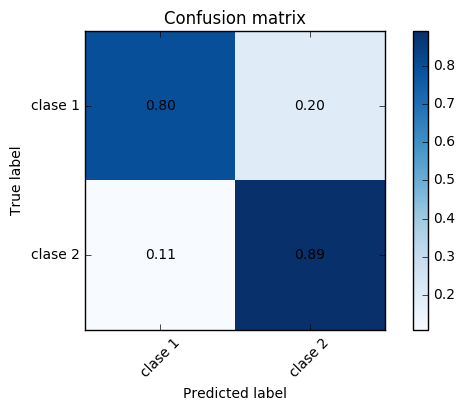

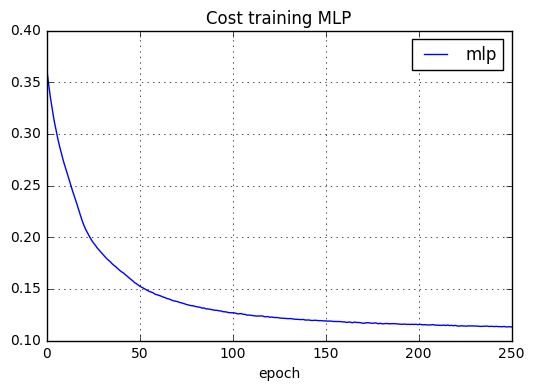

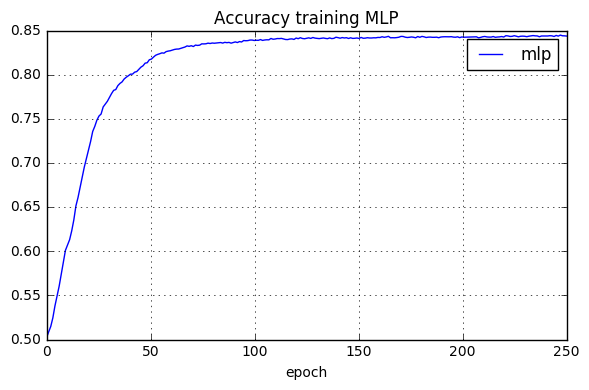

In [4]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_mlp.plot_confusion_matrix()
metrics_mlp.plot_cost(max_epoch, "Cost training MLP")
metrics_mlp.plot_score(max_epoch, "Accuracy training MLP")

plt.tight_layout()

## Training Ensemble - Negative Correlation (Xin Yao, 1999)

The ensemble architecture used in the experiments has four networks. Each individual network is a feedforward network with one hidden layer. Both the hidden node function and the output node function are defined by the logistic function. All the individual networks have ten hidden nodes. The number of training epochs was set to 250. The strength parameter of negative correlations was set to 1.0. These parameters were chosen after limited preliminary experiments. They are not meant to be optimal.

### Training with the same trainig set.

In [5]:
from libml.ensemble.ensemblemodel import EnsembleModel

# Create Ensemble
ensemble_nc = EnsembleModel(name="Ensemble NC")

# Create models for ensemble
for i in range(4):
    net = Sequential(classes_names, "classifier", "net%d_ens_nc" % i)
    net.add_layer(Dense(n_input=data_input.shape[1], n_output=10, activation=T.nnet.sigmoid))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
    net.append_cost(mse)
    net.set_update(sgd, learning_rate=0.1)
    ensemble_nc.append_model(net)

ensemble_nc.add_cost_ensemble(fun_cost=neg_corr, lamb_neg_corr=1.0)  # adds neg correlation in all models
ensemble_nc.compile()

metrics_ensemble = EnsembleClassifierMetrics(ensemble_nc)

for i in range(25):                      
    # training
    tic = time.time()
    metrics = ensemble_nc.fit(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32,
                                validation_jump=validation_jump, early_stop_th=4)
    toc = time.time()

    # Compute metrics
    metrics_ensemble.append_prediction(target_test, ensemble_nc.predict(input_test))
    metrics_ensemble.append_metric(metrics)
    
    # Reset parameters of all ensemble's models
    ensemble_nc.reset()

    print("%d Elapsed time [s]: %f" % (i, toc - tic))

print("FINISHED!")

0 Elapsed time [s]: 16.411718
1 Elapsed time [s]: 16.142518
2 Elapsed time [s]: 15.788681
3 Elapsed time [s]: 15.726009
4 Elapsed time [s]: 15.875513
5 Elapsed time [s]: 15.872980
6 Elapsed time [s]: 16.278467
7 Elapsed time [s]: 16.025048
8 Elapsed time [s]: 16.061814
9 Elapsed time [s]: 15.952731
10 Elapsed time [s]: 15.860788
11 Elapsed time [s]: 16.344194
12 Elapsed time [s]: 16.637611
13 Elapsed time [s]: 16.024267
14 Elapsed time [s]: 15.733506
15 Elapsed time [s]: 16.048656
16 Elapsed time [s]: 16.143602
17 Elapsed time [s]: 16.115610
18 Elapsed time [s]: 16.201818
19 Elapsed time [s]: 15.734500
20 Elapsed time [s]: 16.218953
21 Elapsed time [s]: 15.917621
22 Elapsed time [s]: 16.312646
23 Elapsed time [s]: 16.051677
24 Elapsed time [s]: 16.208071
FINISHED!


### Results Ensemble - Negative Correlation (same training set)

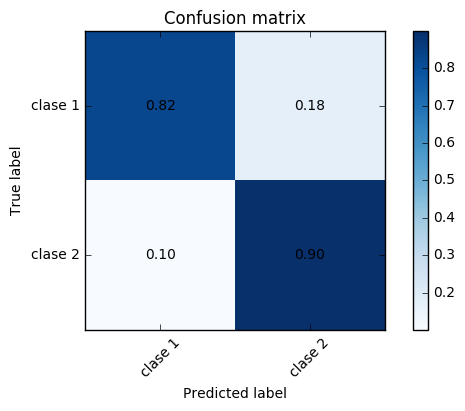

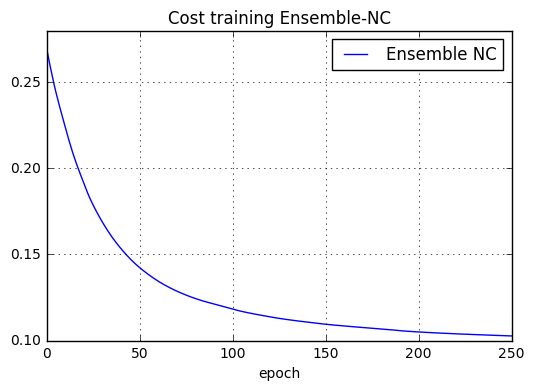

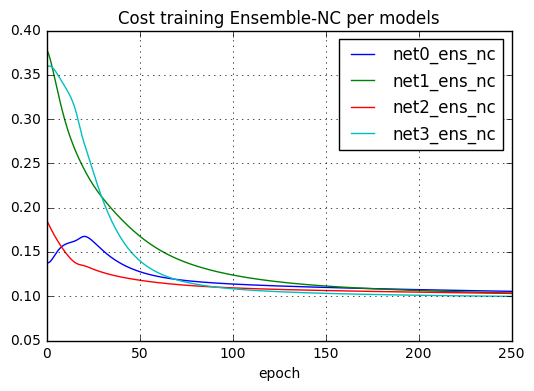

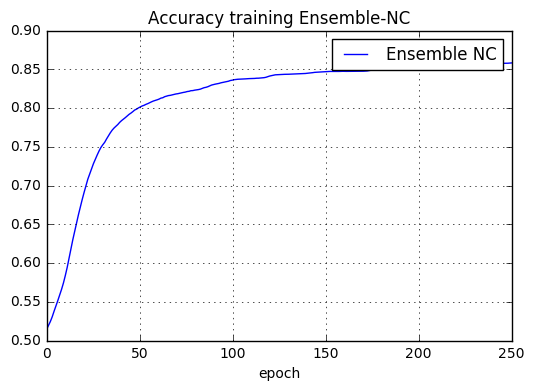

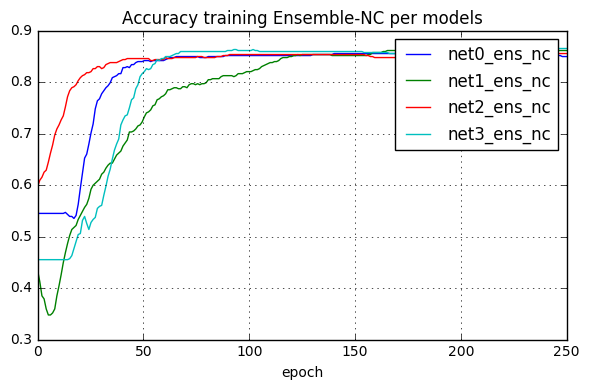

In [6]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_ensemble.plot_confusion_matrix()
metrics_ensemble.plot_cost(max_epoch, "Cost training Ensemble-NC")
metrics_ensemble.plot_cost_models(max_epoch, "Cost training Ensemble-NC per models")
metrics_ensemble.plot_score(max_epoch, "Accuracy training Ensemble-NC")
metrics_ensemble.plot_score_models(max_epoch, "Accuracy training Ensemble-NC per models")

plt.tight_layout()

### Training with the same trainig set.

In [7]:
from libml.ensemble.ensemblemodel import EnsembleModel

# Create Ensemble
ensemble_nc = EnsembleModel(name="Ensemble NC")

# Create models for ensemble
for i in range(4):
    net = Sequential(classes_names, "classifier", "net%d_ens_nc" % i)
    net.add_layer(Dense(n_input=data_input.shape[1], n_output=10, activation=T.nnet.sigmoid))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
    net.append_cost(mse)
    net.set_update(sgd, learning_rate=0.1)
    ensemble_nc.append_model(net)

ensemble_nc.add_cost_ensemble(fun_cost=neg_corr, lamb_neg_corr=1.0)  # adds neg correlation in all models
ensemble_nc.compile()

metrics_ensemble = EnsembleClassifierMetrics(ensemble_nc)

for i in range(25):                      
    # training
    tic = time.time()
    metrics = ensemble_nc.fit_diff_training_set(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32,
                                validation_jump=validation_jump, early_stop_th=4)
    toc = time.time()

    # Compute metrics
    metrics_ensemble.append_prediction(target_test, ensemble_nc.predict(input_test))
    metrics_ensemble.append_metric(metrics)
    
    # Reset parameters of all ensemble's models
    ensemble_nc.reset()

    print("%d Elapsed time [s]: %f" % (i, toc - tic))

print("FINISHED!")

0 Elapsed time [s]: 16.610688
1 Elapsed time [s]: 16.508593
2 Elapsed time [s]: 16.779190
3 Elapsed time [s]: 16.395161
4 Elapsed time [s]: 16.450364
5 Elapsed time [s]: 17.024396
6 Elapsed time [s]: 16.754477
7 Elapsed time [s]: 16.797782
8 Elapsed time [s]: 16.521945
9 Elapsed time [s]: 16.683724
10 Elapsed time [s]: 16.781287
11 Elapsed time [s]: 16.715480
12 Elapsed time [s]: 16.600719
13 Elapsed time [s]: 16.439748
14 Elapsed time [s]: 16.655730
15 Elapsed time [s]: 16.685447
16 Elapsed time [s]: 16.315809
17 Elapsed time [s]: 16.412724
18 Elapsed time [s]: 16.309480
19 Elapsed time [s]: 16.804812
20 Elapsed time [s]: 16.496363
21 Elapsed time [s]: 16.327422
22 Elapsed time [s]: 16.508505
23 Elapsed time [s]: 16.651334
24 Elapsed time [s]: 16.398839
FINISHED!


### Results Ensemble - Negative Correlation (different training set)

<function matplotlib.pyplot.tight_layout>

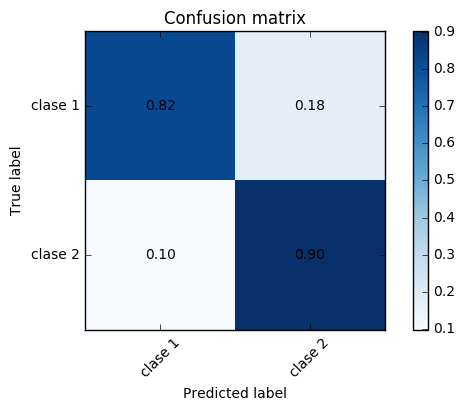

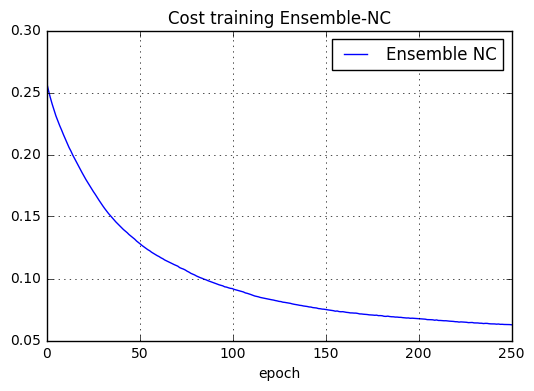

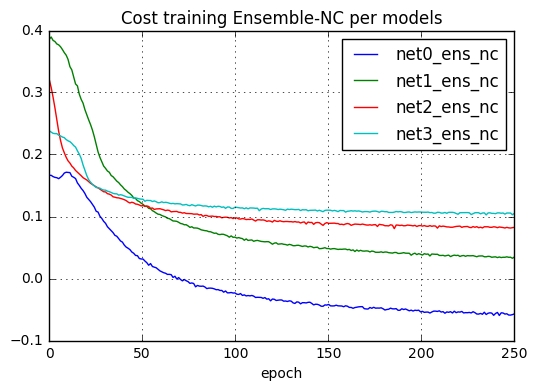

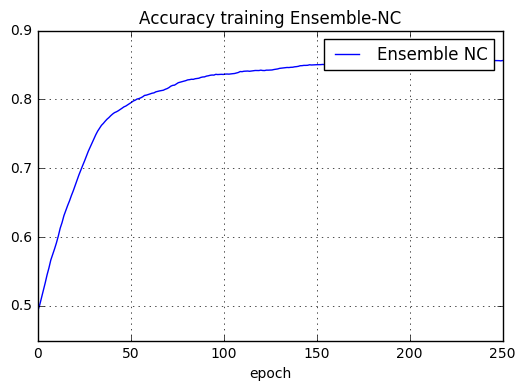

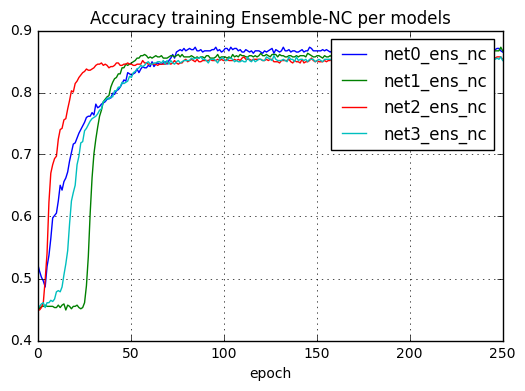

In [8]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_ensemble.plot_confusion_matrix()
metrics_ensemble.plot_cost(max_epoch, "Cost training Ensemble-NC")
metrics_ensemble.plot_cost_models(max_epoch, "Cost training Ensemble-NC per models")
metrics_ensemble.plot_score(max_epoch, "Accuracy training Ensemble-NC")
metrics_ensemble.plot_score_models(max_epoch, "Accuracy training Ensemble-NC per models")

plt.tight_layout